In [1]:
import os 
import time
import sys 
sys.path.append("../training")
import pickle
import copy
from itertools import combinations, permutations
import timeit

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

# Local imports
from save_data import process_data
from threshold import ThresholdModel

np.random.seed(0)

2024-03-31 17:14:16.338791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 17:14:16.450957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-31 17:14:16.450980: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-31 17:14:16.943325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/data/aelabd/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## 1. Data

In [2]:
START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0_resplit"

# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

# load data
X_train_val = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y_train_val = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))
# TODO: Shuffle entire dataset first, then pull out test set (?)

# Shuffle train-val indeces
train_val_shuffler = np.random.permutation(range(X_train_val.shape[0]))
X_train_val = X_train_val[train_val_shuffler, :]
y_train_val = y_train_val[train_val_shuffler]

# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert X_train_val.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert X_test.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

# Small datasets for testing code
X_train_10 = X_train_val[:10,:]
y_train_10 = y_train_val[:10]

In [3]:
# One-hot-encoded data for neural network
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

y_train_val_oh = one_hot_encode(y_train_val)
y_test_oh = one_hot_encode(y_test)
y_train_10_oh = one_hot_encode(y_train_10)

## 2. Helper functions

In [4]:
def split_and_sample_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over sample-axis
    X_I_mean = np.mean(X_I, axis=0)
    X_Q_mean = np.mean(X_Q, axis=0)

    return X_I_mean, X_Q_mean
    
def split_and_time_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over time-axis
    X_I_mean = np.mean(X_I, axis=1)
    X_Q_mean = np.mean(X_Q, axis=1)
    
    return X_I_mean, X_Q_mean

## 3. Neural network

In [5]:
# Optimal hyperparameters per J
INIT_LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.0 # For K-fold cross-validation, we want to define the train-validation split manually
BATCH_SIZE = 12800
EPOCHS = 50
CHECKPOINT_FILENAME = "qmodel_kfcv.h5"
INPUT_SHAPE = (len(X_train_val[0]),)

# Define model with quantized layers 
def construct_NN():
    model = Sequential()
    model.add(QDense(2, input_shape=INPUT_SHAPE, name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    model.add(BatchNormalization())

    # adding pruning 
    pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
    model = prune.prune_low_magnitude(model, **pruning_params)

    return model

def train_NN(X_train, y_train):
    model = construct_NN()
    
    callbacks = [
            ModelCheckpoint(
            CHECKPOINT_FILENAME,
            monitor="val_loss",
            #save_best_only=True,  # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
            save_weights_only=False,
            save_freq="epoch",
        ),
        #ReduceLROnPlateau(patience=75, min_delta=1**-6), # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
        pruning_callbacks.UpdatePruningStep(),
    ]
    
    opt = Adam(learning_rate=INIT_LEARNING_RATE)
    model.compile(
        optimizer=opt, 
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss=CategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        validation_split=VALIDATION_SPLIT, 
        shuffle=True, 
        callbacks=callbacks,
        verbose = 0
    )

    # First remove pruned parameters
    model = strip_pruning(model)

    return model

Just testing the code here

In [6]:
NN_model_10 = train_NN(X_train_10, y_train_10_oh)
print(NN_model_10.summary())

y_pred_NN_10 = np.argmax(NN_model_10.predict(X_test), axis=1)
print(f"Accuracy: {(accuracy_score(y_test, y_pred_NN_10)):.2f}")

2024-03-31 17:14:28.712329: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-31 17:14:28.712384: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-31 17:14:28.712429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2024-03-31 17:14:28.720499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 3082      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 3,090
Trainable params: 3,086
Non-trainable params: 4
_________________________________________________________________
None
3157/3157 [==============================] - 4s 1ms/step
Accuracy: 0.54


## 4. Threshold model: See "QICK demo thresholding.ipynb" and "threshold.py"

Really consists of two parameters

In [7]:
threshold_model_10 = ThresholdModel()
threshold_model_10.fit(X_train_10, y_train_10)
print(f"Model: {threshold_model_10.__dict__}")

y_pred_thresh_10 = threshold_model_10.predict(X_test)
print(f"Accuracy: {(accuracy_score(y_test, y_pred_thresh_10)):.2f}")

Model: {'theta': 1.0379422848687636, 'threshold': 728.1807811684337}
Accuracy: 0.54


## 5. K-fold cross-validation function

In [8]:
def k_fold_cv_split(X_train_val, K): # Warning: bug if N_samples%K != 0 
    out = {} 
    
    indeces = list(range(X_train_val.shape[0]))
    N_samples = len(indeces)
    bin_size = N_samples//K

    # Split the data into K bins
    bins = []
    for i in range(K):
        bin_i = indeces[i*bin_size: (i+1)*bin_size]
        bins.append(bin_i)
    N_in_bins = np.array([len(i) for i in bins])
    

    for i in range(K): # for each round of cross-validation

        # Choose one bin for validation
        val_bin_idx = i
        val_indeces = bins[val_bin_idx]

        # Choose the remaining bins for training 
        train_bin_indeces = [j for j in range(K) if j!= i]
        train_indeces = []
        for j in train_bin_indeces:
            train_indeces.extend(bins[j])
            
        assert(len(train_indeces) + len(val_indeces) == N_samples)
        out_i = {"train_indeces": train_indeces, "val_indeces": val_indeces}
        out[i] = out_i

    return out

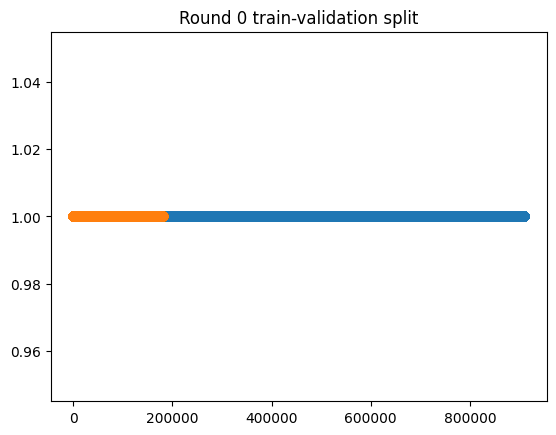

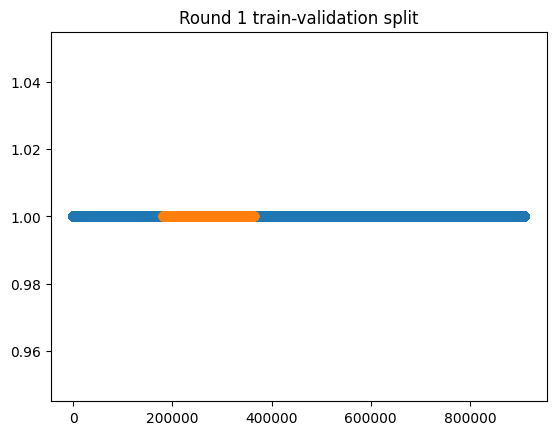

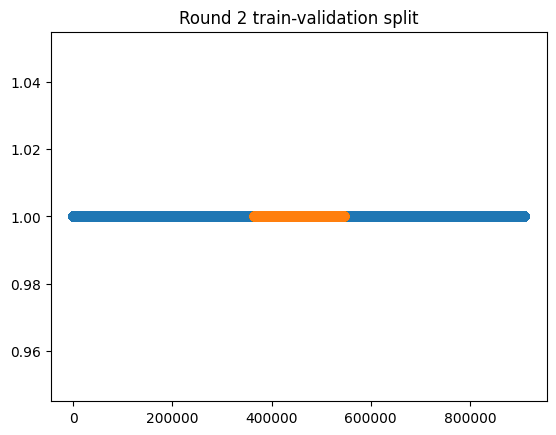

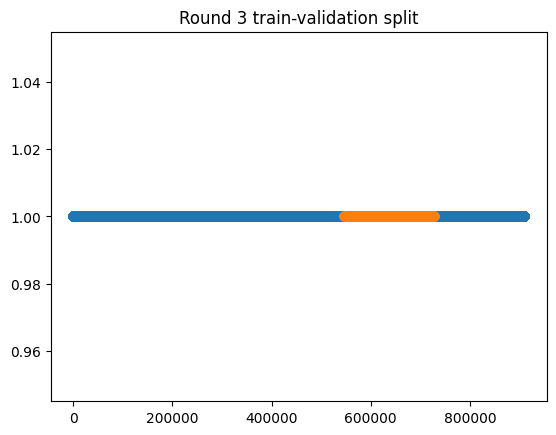

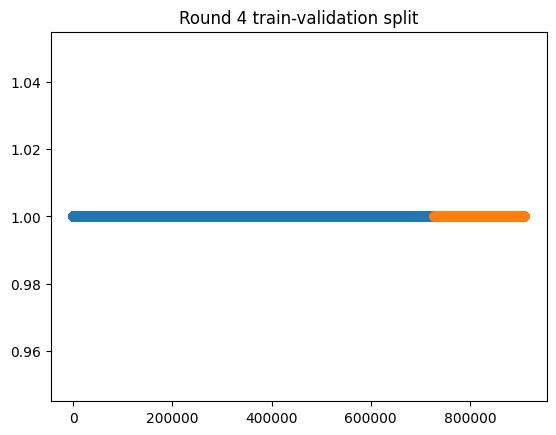

In [9]:
five_fold_cv_indeces = k_fold_cv_split(X_train_val, 5)

for k, v in five_fold_cv_indeces.items():
    train_indeces = v["train_indeces"]
    val_indeces = v["val_indeces"]

    train_y = np.ones(len(train_indeces))
    val_y = np.ones(len(val_indeces))

    plt.figure()
    plt.scatter(train_indeces, train_y, label = "Training indeces")
    plt.scatter(val_indeces, val_y, label = "Validation indeces")
    plt.title(f"Round {k} train-validation split")
    plt.show()
    plt.close()
    

## 6. Run 5-fold CV, compare models

In [ ]:
K = 10
K_fold_cv_indeces = k_fold_cv_split(X_train_val, K)

NN_acc = []
threshold_acc = []

tic = time.time()

for i in range(K):
    train_val_split = K_fold_cv_indeces[i]
    train_indeces = train_val_split["train_indeces"]
    val_indeces = train_val_split["val_indeces"]

    X_train_i = X_train_val[train_indeces, :]
    y_train_i = y_train_val[train_indeces]
    y_train_oh_i = y_train_val_oh[train_indeces]
    
    X_val_i = X_train_val[val_indeces, :]
    y_val_i = y_train_val[val_indeces]
    y_val_oh_i = y_train_val_oh[val_indeces]

    # Train, evaluate neural network
    NN_i = train_NN(X_train_i, y_train_oh_i)
    y_pred_NN_i = np.argmax(NN_i.predict(X_val_i), axis=1)
    NN_acc_i = accuracy_score(y_val_i, y_pred_NN_i)
    NN_acc.append(NN_acc_i)

    # Train, evaluate threshold model
    threshold_model_i = ThresholdModel()
    threshold_model_i.fit(X_train_i, y_train_i)
    y_pred_thresh_i = threshold_model_i.predict(X_val_i)
    threshold_acc_i = accuracy_score(y_val_i, y_pred_thresh_i)
    threshold_acc.append(threshold_acc_i)

toc = time.time()
dur = toc - tic
print(f"Total duration: {dur//60} minutes, {dur%60} seconds")

2841/2841 [==============================] - 3s 920us/step


In [ ]:
plt.figure()
plt.plot(range(K), NN_acc, label = f"Neural network, mean accuracy = {(100*np.mean(np.array(NN_acc))):.3f}%")
plt.plot(range(K), threshold_acc, label = f"Thresholding, mean accuracy = {(100*np.mean(np.array(threshold_acc))):.3f}%")
plt.xlabel("Validation bin")
plt.ylabel("Accuracy")
plt.title(f"Neural network vs. thresholding: {K}-fold cross-validation")
plt.legend()
plt.savefig(f"{K}_fold_CV.png")
plt.show()
plt.close()

## 7. Visualization

In [5]:
X_train = X_train_val[:int(0.7*X_train_val.shape[0]), :]
y_train = y_train_val[:int(0.7*y_train_val.shape[0])]
y_train_oh = one_hot_encode(y_train)

In [6]:
# NN_model = train_NN(X_train, y_train_oh)
# y_pred_NN = np.argmax(NN_model.predict(X_test), axis=1)

threshold_model = ThresholdModel()
threshold_model.fit(X_train, y_train)
y_pred_thresh = threshold_model.predict(X_test)

In [7]:
def plot_pred(X, y, y_pred, alpha=0.1):

    # True positives
    idx_true_pos = np.where((y==1)&(y_pred==1))[0]
    X_tp = X[idx_true_pos]
    X_tp_I, X_tp_Q = split_and_time_average(X_tp)

    # False negatives
    idx_false_neg = np.where((y==1)&(y_pred==0))[0]
    X_fn = X[idx_false_neg]
    X_fn_I, X_fn_Q = split_and_time_average(X_fn)

    # True negatives
    idx_true_neg = np.where((y==0)&(y_pred==0))[0]
    X_tn = X[idx_true_neg]
    X_tn_I, X_tn_Q = split_and_time_average(X_tn)
    
    # False positives
    idx_false_pos = np.where((y==0)&(y_pred==1))[0]
    X_fp = X[idx_false_pos]
    X_fp_I, X_fp_Q = split_and_time_average(X_fp)


    ################### Plot ###########################
    fig, ax = plt.subplots(1, figsize = (6,5))
    ax.scatter(X_tn_I, X_tn_Q, alpha=alpha, label = "Ground, labeled ground")
    ax.scatter(X_fp_I, X_fp_Q, alpha=alpha, label = "Ground, labeled excited")
    ax.scatter(X_fn_I, X_fn_Q, alpha=alpha, label = "Excited, labeled ground")
    ax.scatter(X_tp_I, X_tp_Q, alpha=alpha, label = "Excited, labeled excited")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    
    return fig, ax

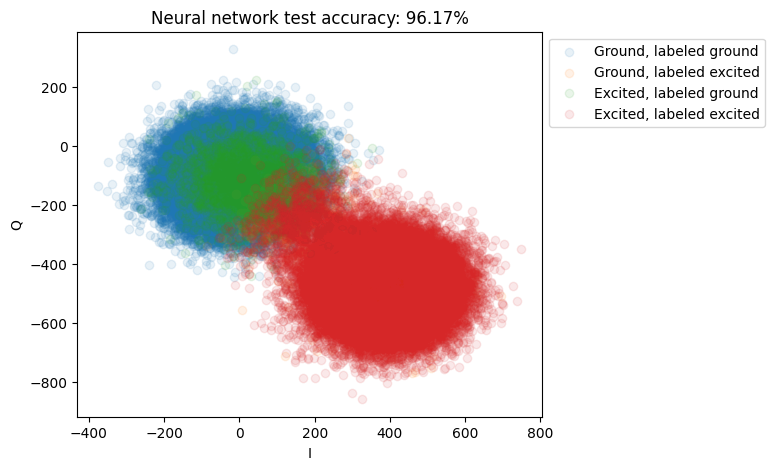

In [15]:
acc_NN = accuracy_score(y_test, y_pred_NN)
fig_NN_pred, ax_NN_pred = plot_pred(X_test, y_test, y_pred_NN)
ax_NN_pred.set_title(f"Neural network test accuracy: {(100*acc_NN):.2f}%")
ax_NN_pred.legend(bbox_to_anchor = (1,1))

Text(0.5, 1.0, 'Threshold model test accuracy: 95.81%')

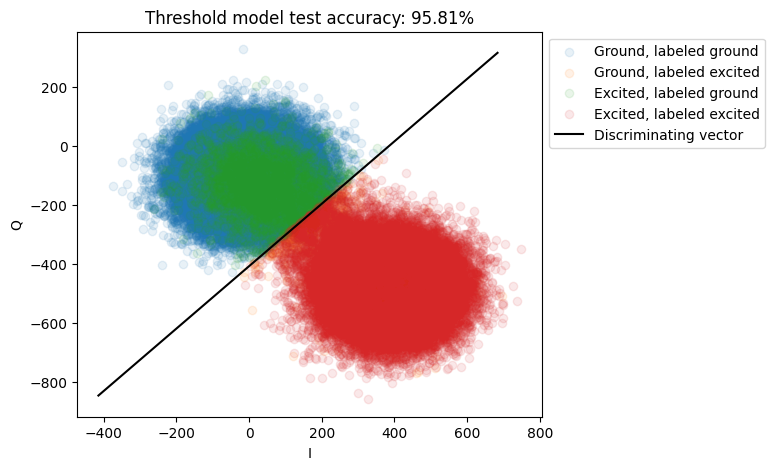

In [8]:
acc_thresh = accuracy_score(y_test, y_pred_thresh)
fig_thresh_pred, ax_thresh_pred = plot_pred(X_test, y_test, y_pred_thresh)

x_thresh = threshold_model.threshold*np.ones(1000)
y_thresh = np.linspace(-900, 700, 1000)    
y_thresh_prime = x_thresh*np.sin(-threshold_model.theta) + y_thresh*np.cos(-threshold_model.theta)
x_thresh_prime = x_thresh*np.cos(-threshold_model.theta) - y_thresh*np.sin(-threshold_model.theta)
ax_thresh_pred.plot(x_thresh_prime, y_thresh_prime, label = "Discriminating vector", color = "black")

ax_thresh_pred.legend(bbox_to_anchor = (1, 1))
ax_thresh_pred.set_title(f"Threshold model test accuracy: {(100*acc_thresh):.2f}%")

In [24]:
def plot_traces(X, y, y_pred):

    # True positives
    idx_true_pos = np.where((y==1)&(y_pred==1))[0]
    X_tp = X[idx_true_pos]
    X_tp_I, X_tp_Q = split_and_sample_average(X_tp)
    

    # False negatives
    idx_false_neg = np.where((y==1)&(y_pred==0))[0]
    X_fn = X[idx_false_neg]
    X_fn_I, X_fn_Q = split_and_sample_average(X_fn)

    # True negatives
    idx_true_neg = np.where((y==0)&(y_pred==0))[0]
    X_tn = X[idx_true_neg]
    X_tn_I, X_tn_Q = split_and_sample_average(X_tn)
    
    # False positives
    idx_false_pos = np.where((y==0)&(y_pred==1))[0]
    X_fp = X[idx_false_pos]
    X_fp_I, X_fp_Q = split_and_sample_average(X_fp)


    ################### Plot ###########################
    fig, (ax_I, ax_Q) = plt.subplots(2,1, figsize = (12, 8))
    ax_I.plot(range(X_tn_I.shape[0]), X_tn_I, label = "Label = ground, Prediction = ground")
    ax_I.plot(range(X_fp_I.shape[0]), X_fp_I, label = "Label = ground, Prediction = excited")
    ax_I.plot(range(X_fn_I.shape[0]), X_fn_I, label = "Label = excited, Prediction = ground")
    ax_I.plot(range(X_tp_I.shape[0]), X_tp_I, label = "Label = excited, Prediction = excited")
    ax_I.set_xlabel("Clock cycle (~3ns)")
    ax_I.set_ylabel("I")
    ax_I.legend(bbox_to_anchor = (1,1))
    
    ax_Q.plot(range(X_tn_Q.shape[0]), X_tn_Q, label = "Label = ground, Prediction = ground")
    ax_Q.plot(range(X_fp_Q.shape[0]), X_fp_Q, label = "Label = ground, Prediction = excited")
    ax_Q.plot(range(X_fn_Q.shape[0]), X_fn_Q, label = "Label = excited, Prediction = ground")
    ax_Q.plot(range(X_tp_Q.shape[0]), X_tp_Q, label = "Label = excited, Prediction = excited")
    ax_Q.set_xlabel("Clock cycle (~3ns)")
    ax_Q.set_ylabel("Q")
    ax_Q.legend(bbox_to_anchor = (1,1))
    
    return fig, (ax_I, ax_Q)

Text(0.5, 0.98, 'Neural network')

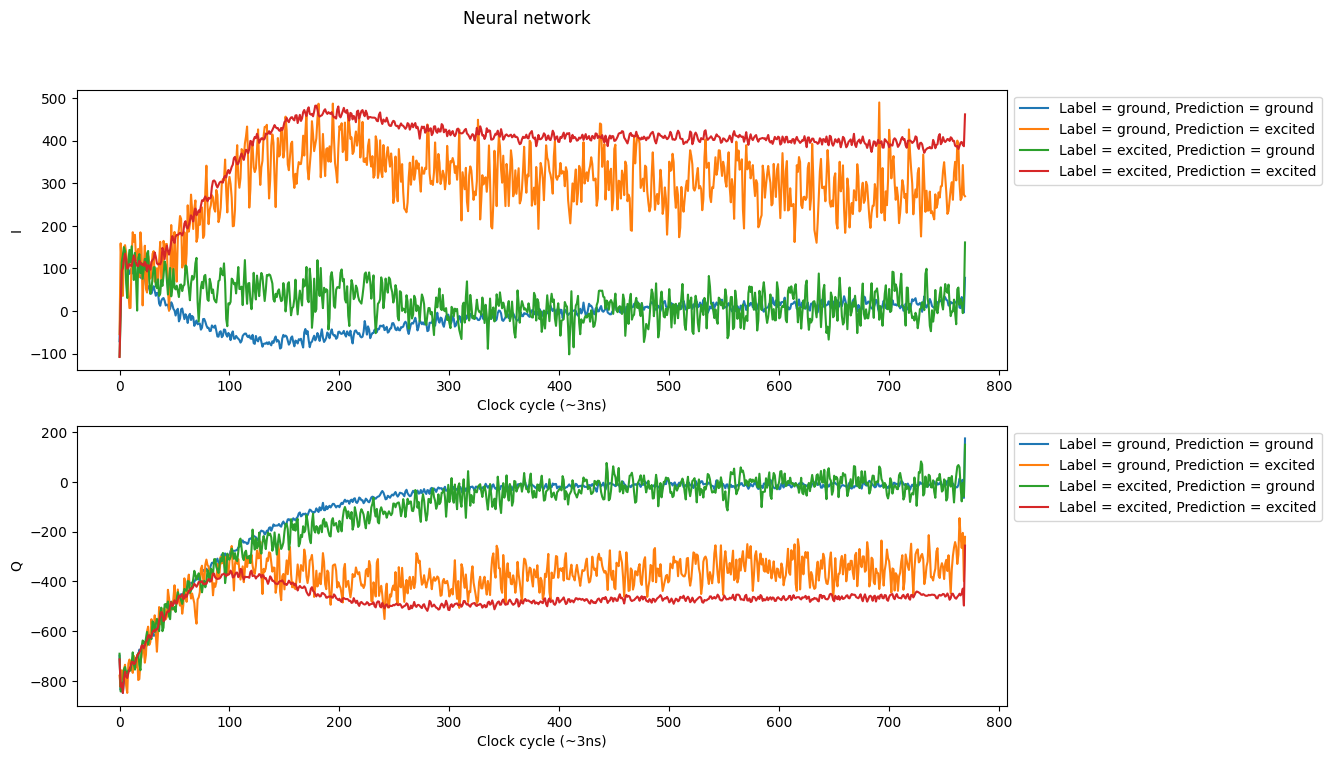

In [25]:
fig_NN_trace, (ax_I_NN_trace, ax_Q_NN_trace) = plot_traces(X_test, y_test, y_pred_NN)
fig_NN_trace.suptitle("Neural network")

Text(0.5, 0.98, 'Threshold model')

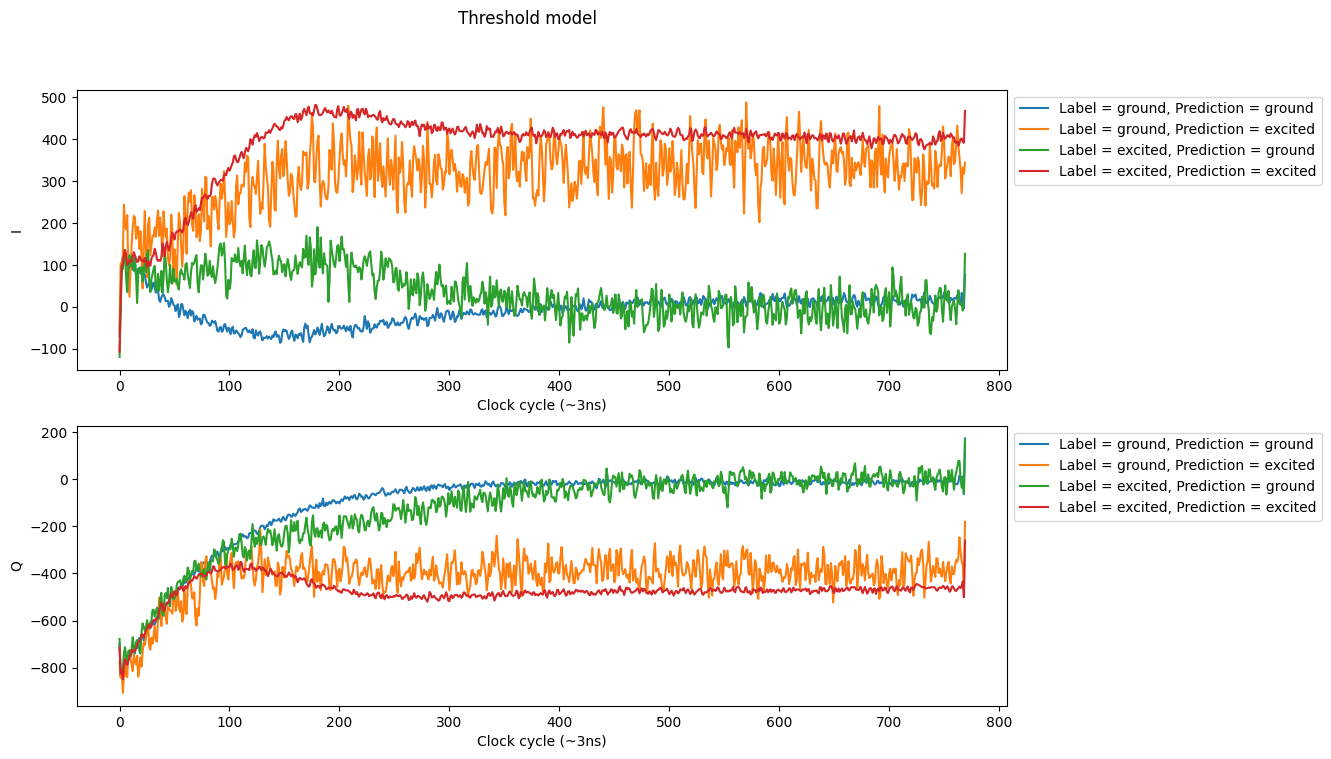

In [26]:
fig_thresh_trace, (ax_I_thresh_trace, ax_Q_thresh_trace) = plot_traces(X_test, y_test, y_pred_thresh)
fig_thresh_trace.suptitle("Threshold model")